In [49]:
!pip install pmdarima

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from timeit import default_timer as timer
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [51]:
quantity_competitor = [4864172, 10889213, 4774831, 9768208, 6012674, 9402112, 11288509, 7350389, 3838228, 6486889, 7652448]
value_competitor = [2660089, 6350758, 3683155, 7189822, 4103657, 6094928, 3749908, 4775025, 2533290, 2420021, 3345337]

quantity_plan = [735, 330,	560, 750, 730, 450, 600, 450, 555, 600, 400, 800]
value_plan = [68, 31, 58, 77, 75, 46, 62, 46, 57, 62, 41, 82]

# Create the DataFrame
df = pd.DataFrame({
    'quarter': range(1, 12),
    'competitor_quantity': quantity_competitor,
    'competitor_value': value_competitor,
    'quantity': quantity_plan[:11],
    'value': value_plan[:11]
})

print(df)

    quarter  competitor_quantity  competitor_value  quantity  value
0         1              4864172           2660089       735     68
1         2             10889213           6350758       330     31
2         3              4774831           3683155       560     58
3         4              9768208           7189822       750     77
4         5              6012674           4103657       730     75
5         6              9402112           6094928       450     46
6         7             11288509           3749908       600     62
7         8              7350389           4775025       450     46
8         9              3838228           2533290       555     57
9        10              6486889           2420021       600     62
10       11              7652448           3345337       400     41


In [52]:
df[['competitor_quantity', 'competitor_value', 'quantity', 'value']] = df[['competitor_quantity', 'competitor_value', 'quantity', 'value']].astype(float)

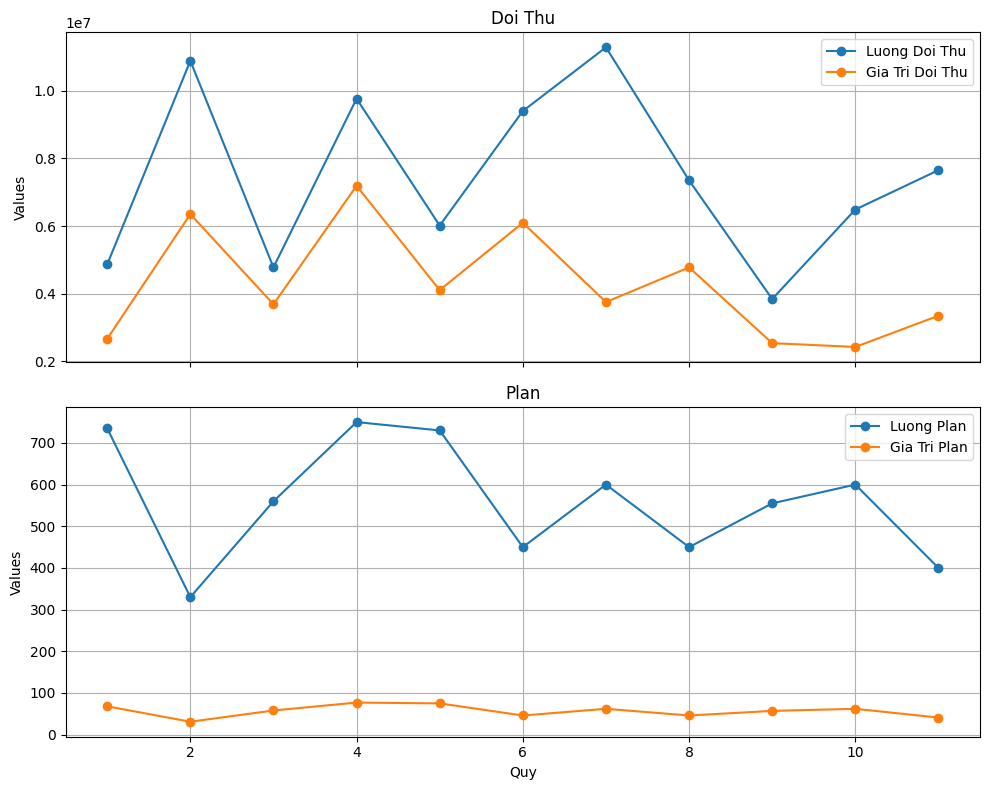

In [53]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plotting for 'doi_thu'
ax1.plot(df['quarter'], df['competitor_quantity'], marker='o', label='Luong Doi Thu')
ax1.plot(df['quarter'], df['competitor_value'], marker='o', label='Gia Tri Doi Thu')
ax1.set_title('Doi Thu')
ax1.set_ylabel('Values')
ax1.legend()
ax1.grid(True)

# Plotting for 'plan'
ax2.plot(df['quarter'], df['quantity'], marker='o', label='Luong Plan')
ax2.plot(df['quarter'], df['value'], marker='o', label='Gia Tri Plan')
ax2.set_title('Plan')
ax2.set_xlabel('Quy')
ax2.set_ylabel('Values')
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

# Checking Stationary

## Competitor Quantity

In [54]:
result = adfuller(df['competitor_quantity'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature: competitor quantity")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

Dickey-Fuller test for feature: competitor quantity
Test Statistic: -4.125687
p-value: 0.000878
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749
Reject H0 - Time Series is Stationary


## Competitor Value

In [55]:
result = adfuller(df['competitor_value'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature: competitor value")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

Dickey-Fuller test for feature: competitor value
Test Statistic: -0.139745
p-value: 0.945333
Critical Values:
	1%: -4.473
	5%: -3.290
	10%: -2.772
Failed to Reject H0 - Time Series is Non-Stationary


## Quantity

In [56]:
result = adfuller(df['quantity'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature: quantity")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

Dickey-Fuller test for feature: quantity
Test Statistic: -3.610337
p-value: 0.005566
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749
Reject H0 - Time Series is Stationary


## Value

In [57]:
result = adfuller(df['value'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature: value")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

Dickey-Fuller test for feature: value
Test Statistic: -3.235277
p-value: 0.018031
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749
Reject H0 - Time Series is Stationary


### Mitigating the problem of non-stationary

In [58]:
df['competitor_value_diff'] = df['competitor_value'].diff()

# Fill the missing value in the differenced series with the first observation of the original series
df['competitor_value_diff'].iloc[0] = df['competitor_value'].iloc[0]

In [59]:
data_uti = df[['competitor_quantity', 'competitor_value_diff', 'quantity', 'value']]

In [60]:
data_uti

,competitor_quantity,competitor_value_diff,quantity,value
0,4864172.0,2660089.0,735.0,68.0
1,10889213.0,3690669.0,330.0,31.0
2,4774831.0,-2667603.0,560.0,58.0
3,9768208.0,3506667.0,750.0,77.0
4,6012674.0,-3086165.0,730.0,75.0
5,9402112.0,1991271.0,450.0,46.0
6,11288509.0,-2345020.0,600.0,62.0
7,7350389.0,1025117.0,450.0,46.0
8,3838228.0,-2241735.0,555.0,57.0
9,6486889.0,-113269.0,600.0,62.0


In [61]:
data_uti.rename(
    columns={"competitor_value_diff": "competitor_value"},
    inplace=True,
)

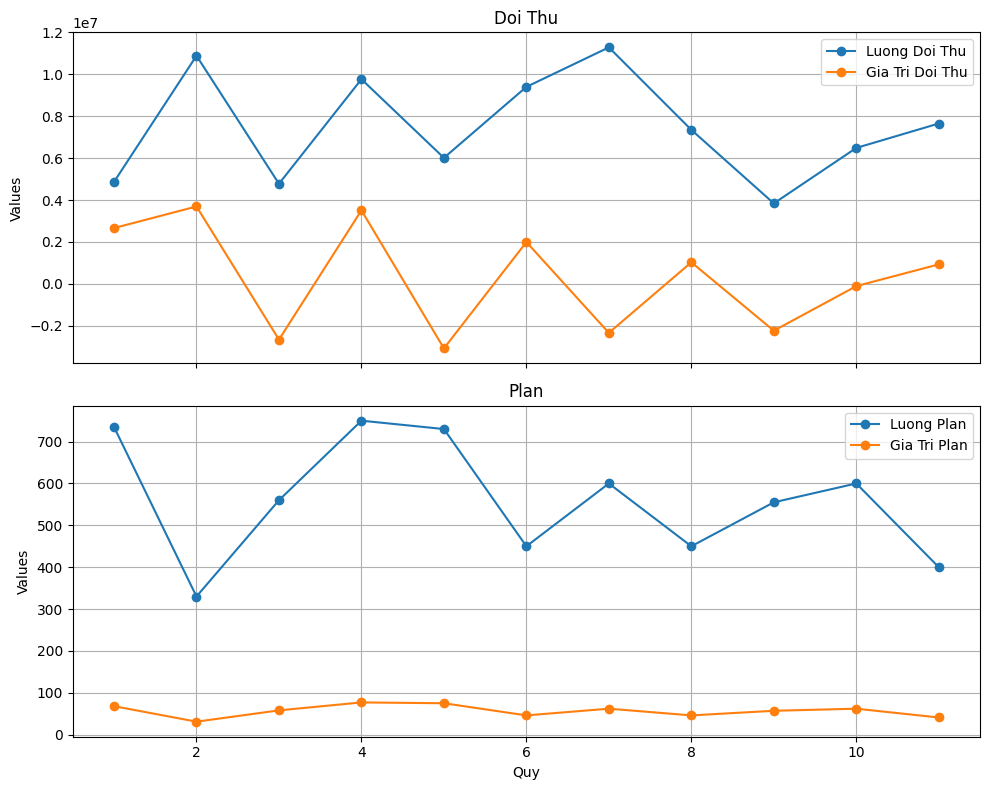

In [63]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plotting for 'doi_thu'
ax1.plot(range(1, 12), data_uti['competitor_quantity'], marker='o', label='Luong Doi Thu')
ax1.plot(range(1, 12), data_uti['competitor_value'], marker='o', label='Gia Tri Doi Thu')
ax1.set_title('Doi Thu')
ax1.set_ylabel('Values')
ax1.legend()
ax1.grid(True)

# Plotting for 'plan'
ax2.plot(range(1, 12), data_uti['quantity'], marker='o', label='Luong Plan')
ax2.plot(range(1, 12), data_uti['value'], marker='o', label='Gia Tri Plan')
ax2.set_title('Plan')
ax2.set_xlabel('Quy')
ax2.set_ylabel('Values')
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

In [64]:
result = adfuller(data_uti['competitor_value'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature: competitor value after Differencing")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

Dickey-Fuller test for feature: competitor value after Differencing
Test Statistic: -5.643214
p-value: 0.000001
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749
Reject H0 - Time Series is Stationary


## Correlation Testing

In [65]:
from statsmodels.tsa.stattools import grangercausalitytests

# Select the desired columns excluding 'quarter'
selected_columns = df.columns.difference(['quarter', 'competitor_value_diff'])
correlation_matrix = df[selected_columns].corr(method='pearson')

In [66]:
print(correlation_matrix)

                     competitor_quantity  competitor_value  quantity     value
competitor_quantity             1.000000          0.695833 -0.316249 -0.296152
competitor_value                0.695833          1.000000 -0.183705 -0.168095
quantity                       -0.316249         -0.183705  1.000000  0.986605
value                          -0.296152         -0.168095  0.986605  1.000000


# Training

## Splitting Data

In [72]:
# Split the dataset into train and test
train_data = data_uti[:8]
test_data = data_uti[8:]

# Optional: Reset the index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [73]:
print(train_data)
print(test_data)

   competitor_quantity  competitor_value  quantity  value
0            4864172.0         2660089.0     735.0   68.0
1           10889213.0         3690669.0     330.0   31.0
2            4774831.0        -2667603.0     560.0   58.0
3            9768208.0         3506667.0     750.0   77.0
4            6012674.0        -3086165.0     730.0   75.0
5            9402112.0         1991271.0     450.0   46.0
6           11288509.0        -2345020.0     600.0   62.0
7            7350389.0         1025117.0     450.0   46.0
   competitor_quantity  competitor_value  quantity  value
0            3838228.0        -2241735.0     555.0   57.0
1            6486889.0         -113269.0     600.0   62.0
2            7652448.0          925316.0     400.0   41.0


## Competitor Quantity

In [ ]:
target_variable_cq = 'competitor_quantity'

# Extract the time series data for the target variable
ts_cq = train_data[target_variable_cq]

# Apply auto_arima to find the best ARIMA model
stepwise_model_cq = auto_arima(ts_cq, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_cq.summary())

## Competitor Value

In [ ]:
target_variable_cv = 'competitor_value'

# Extract the time series data for the target variable
ts_cv = train_data[target_variable_cv]

# Apply auto_arima to find the best ARIMA model
stepwise_model_cv = auto_arima(ts_cv, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_cv.summary())

## Quantity

In [ ]:
target_variable_q = 'quantity'

# Extract the time series data for the target variable
ts_q = train_data[target_variable_q]

# Apply auto_arima to find the best ARIMA model
stepwise_model_q = auto_arima(ts_q, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_q.summary())

## Value

In [ ]:
target_variable_v = 'value'

# Extract the time series data for the target variable
ts_v = train_data[target_variable_v]

# Apply auto_arima to find the best ARIMA model
stepwise_model_v = auto_arima(ts_v, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_v.summary())

## Final

In [ ]:
target_variable = 'value'
ts = train_data[target_variable]

best_model_high= auto_arima(ts, start_p=0, d=1, start_q=0,
           max_p=200, max_d=200, max_q=200, seasonal=False,
           trace=True, suppress_warnings=True, stepwise=False)

print(best_model_high.summary())

In [ ]:
forecast = best_model_high.predict(n_periods=3, return_conf_int=True)

In [ ]:
predicted_values = forecast[0]
print(predicted_values)

## Evaluating

In [74]:
from statsmodels.tsa.vector_ar.var_model import VAR

#make final predictions
model = VAR(endog=data_uti)
model_fit = model.fit()

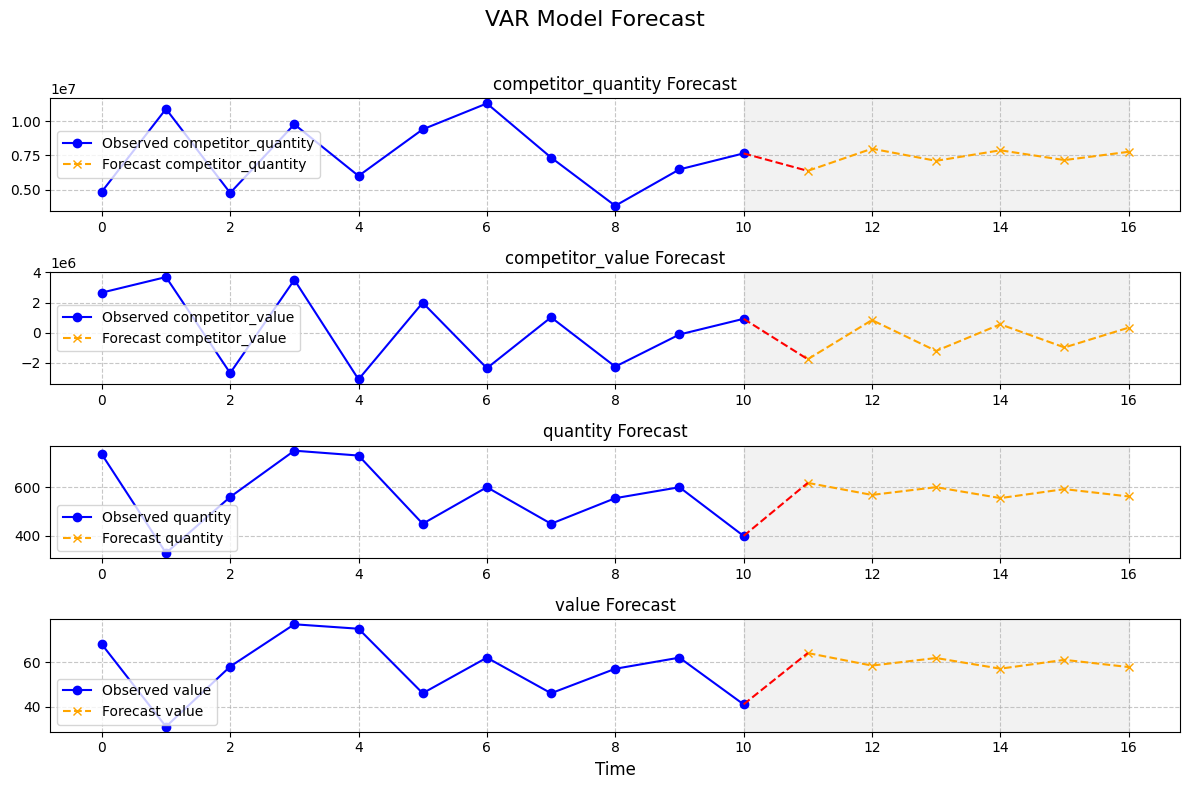

In [90]:
# Make forecasts
forecast_steps = 6  # You can adjust the number of forecast steps
forecast = model_fit.forecast(model_fit.model.y, steps=forecast_steps)

# Plot the results
fig, axes = plt.subplots(nrows=data_uti.shape[1], ncols=1, figsize=(12, 8))

for i, (col, ax) in enumerate(zip(data_uti.columns, axes)):
    # Plot original data
    ax.plot(data_uti.index, data_uti[col], label=f'Observed {col}', linestyle='-', marker='o', color='blue')

    # Plot forecast
    forecast_index = range(data_uti.index[-1] + 1, data_uti.index[-1] + forecast_steps + 1)
    ax.plot(forecast_index, forecast[:, i], label=f'Forecast {col}', linestyle='--', marker='x', color='orange')

    # Connect the last observed value to the first forecasted value
    ax.plot([data_uti.index[-1], forecast_index[0]], [data_uti[col].iloc[-1], forecast[0, i]], linestyle='--', color='red')

    ax.legend()

    # Highlight forecast period
    ax.axvspan(data_uti.index[-1], forecast_index[-1], alpha=0.1, color='gray')

    # Set grid and title
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(f'{col} Forecast')

# Add titles and labels
plt.suptitle('VAR Model Forecast', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to prevent title overlap
plt.show()


In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'data_uti' is your original time series data
# Assuming 'forecast' is the forecasted values

# Calculate RMSE, MAE, and MAPE for each column
metrics = {}
for i, col in enumerate(data_uti.columns):
    observed = data_uti[col].values
    predicted = forecast[:, i]

    # RMSE
    rmse = np.sqrt(mean_squared_error(observed[-6:], predicted))

    # MAE
    mae = mean_absolute_error(observed[-6:], predicted)

    # MAPE
    mape = np.mean(np.abs((observed[-6:] - predicted) / observed[-6:])) * 100

    metrics[col] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Print or store the metrics
for col, metric_values in metrics.items():
    print(f'Metrics for {col}:')
    print(f'RMSE: {metric_values["RMSE"]:.2f}')
    print(f'MAE: {metric_values["MAE"]:.2f}')
    print(f'MAPE: {metric_values["MAPE"]:.2f}%')
    print()


Metrics for competitor_quantity:
RMSE: 2477928.83
MAE: 1898389.55
MAPE: 30.30%

Metrics for competitor_value:
RMSE: 2518800.94
MAE: 2233808.56
MAPE: 247.86%

Metrics for quantity:
RMSE: 114.07
MAE: 86.65
MAPE: 19.64%

Metrics for value:
RMSE: 12.06
MAE: 9.21
MAPE: 20.34%

